/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Date and Time:  14-Nov-2022 (17:17:39)
Runs: 2
BO Iterations: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%
-------------------
Emulator?: False
______________________________
Sparse Grid?: False
Objective Function: obj
-  -  -  -  -  -  -  -  -  -  -
Separation Factor Train/Test: 0.9
Lengthscale Set To: None
Explore Bias Multiplier: 0.3
Run Number:  1


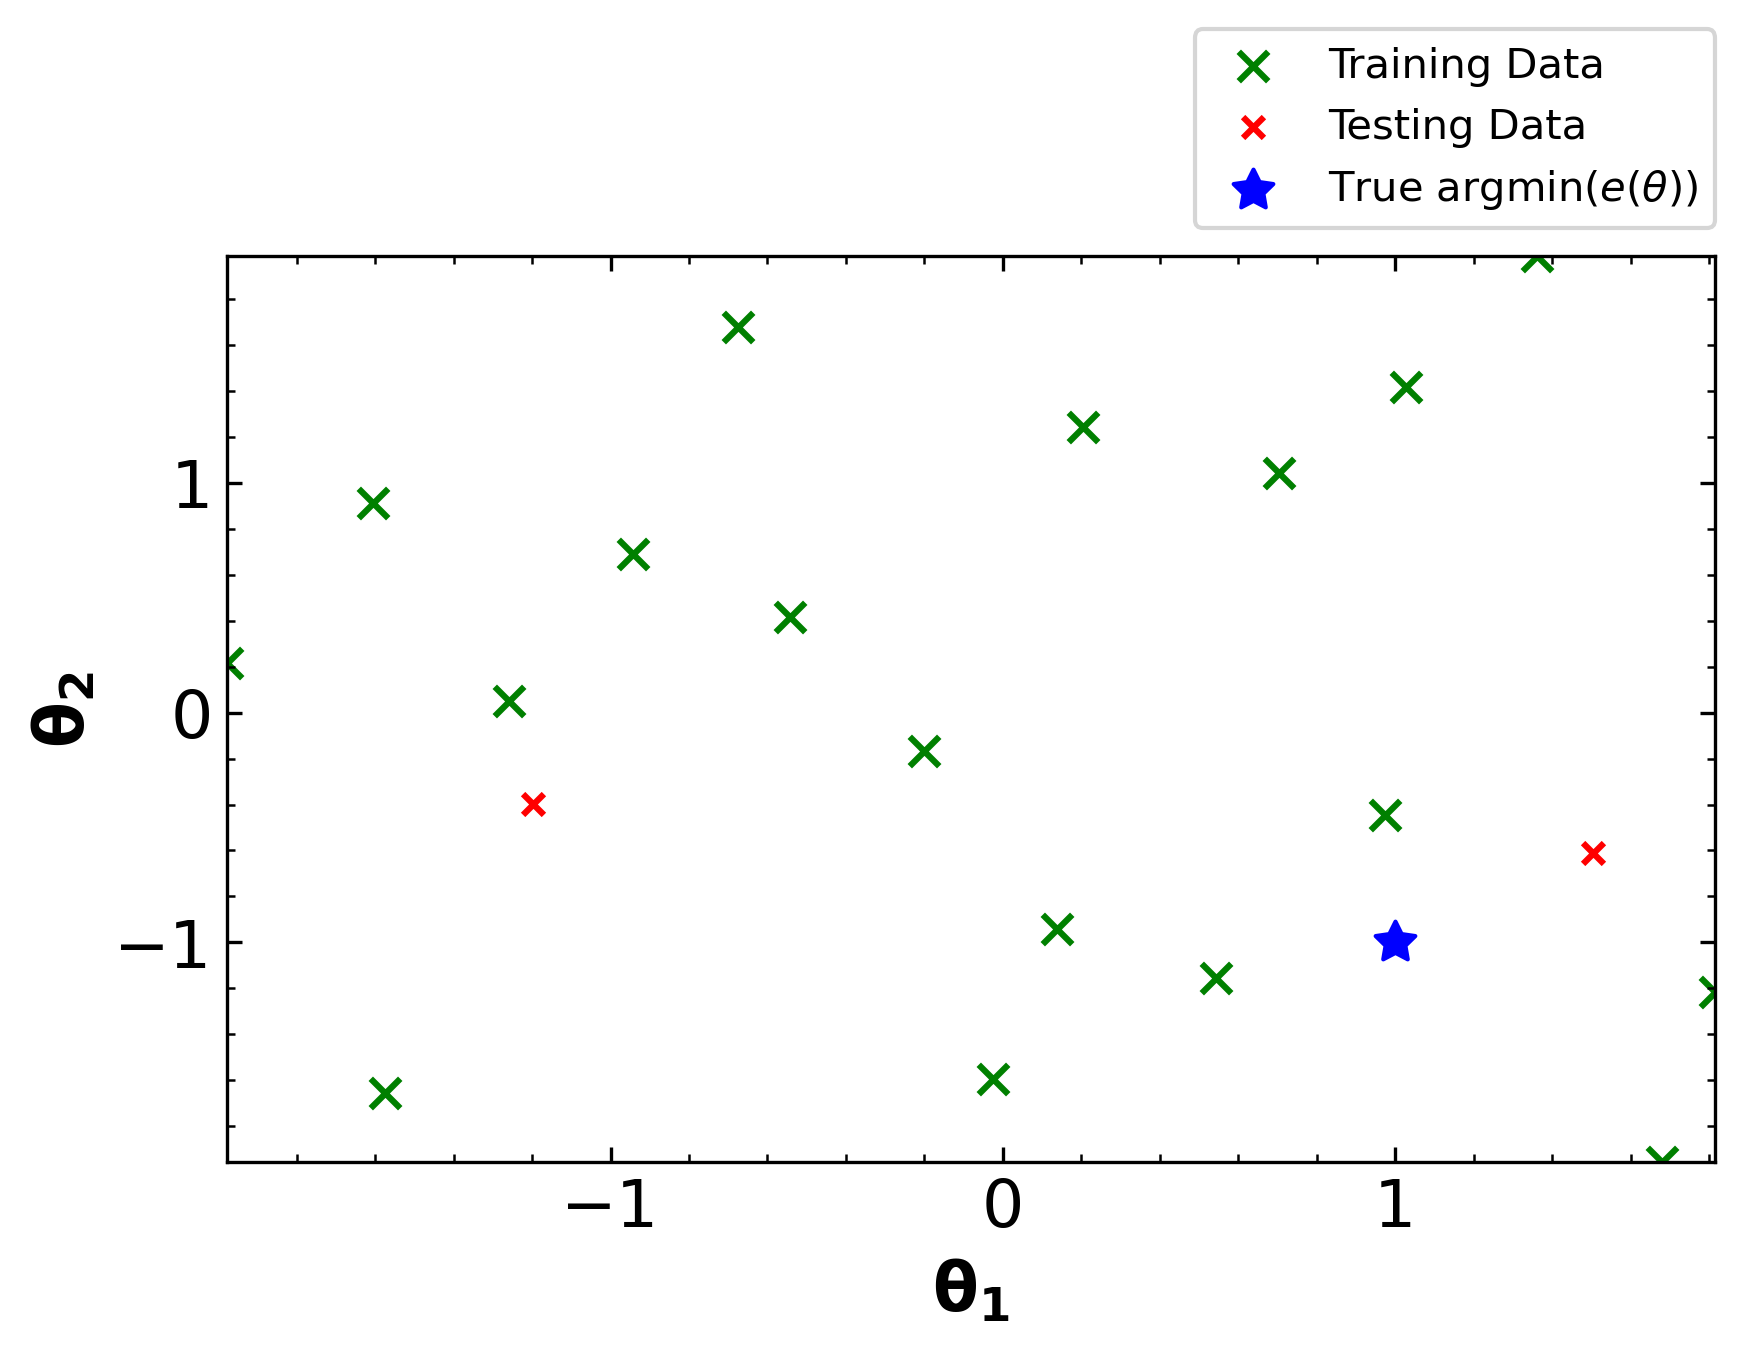

Run Number:  2


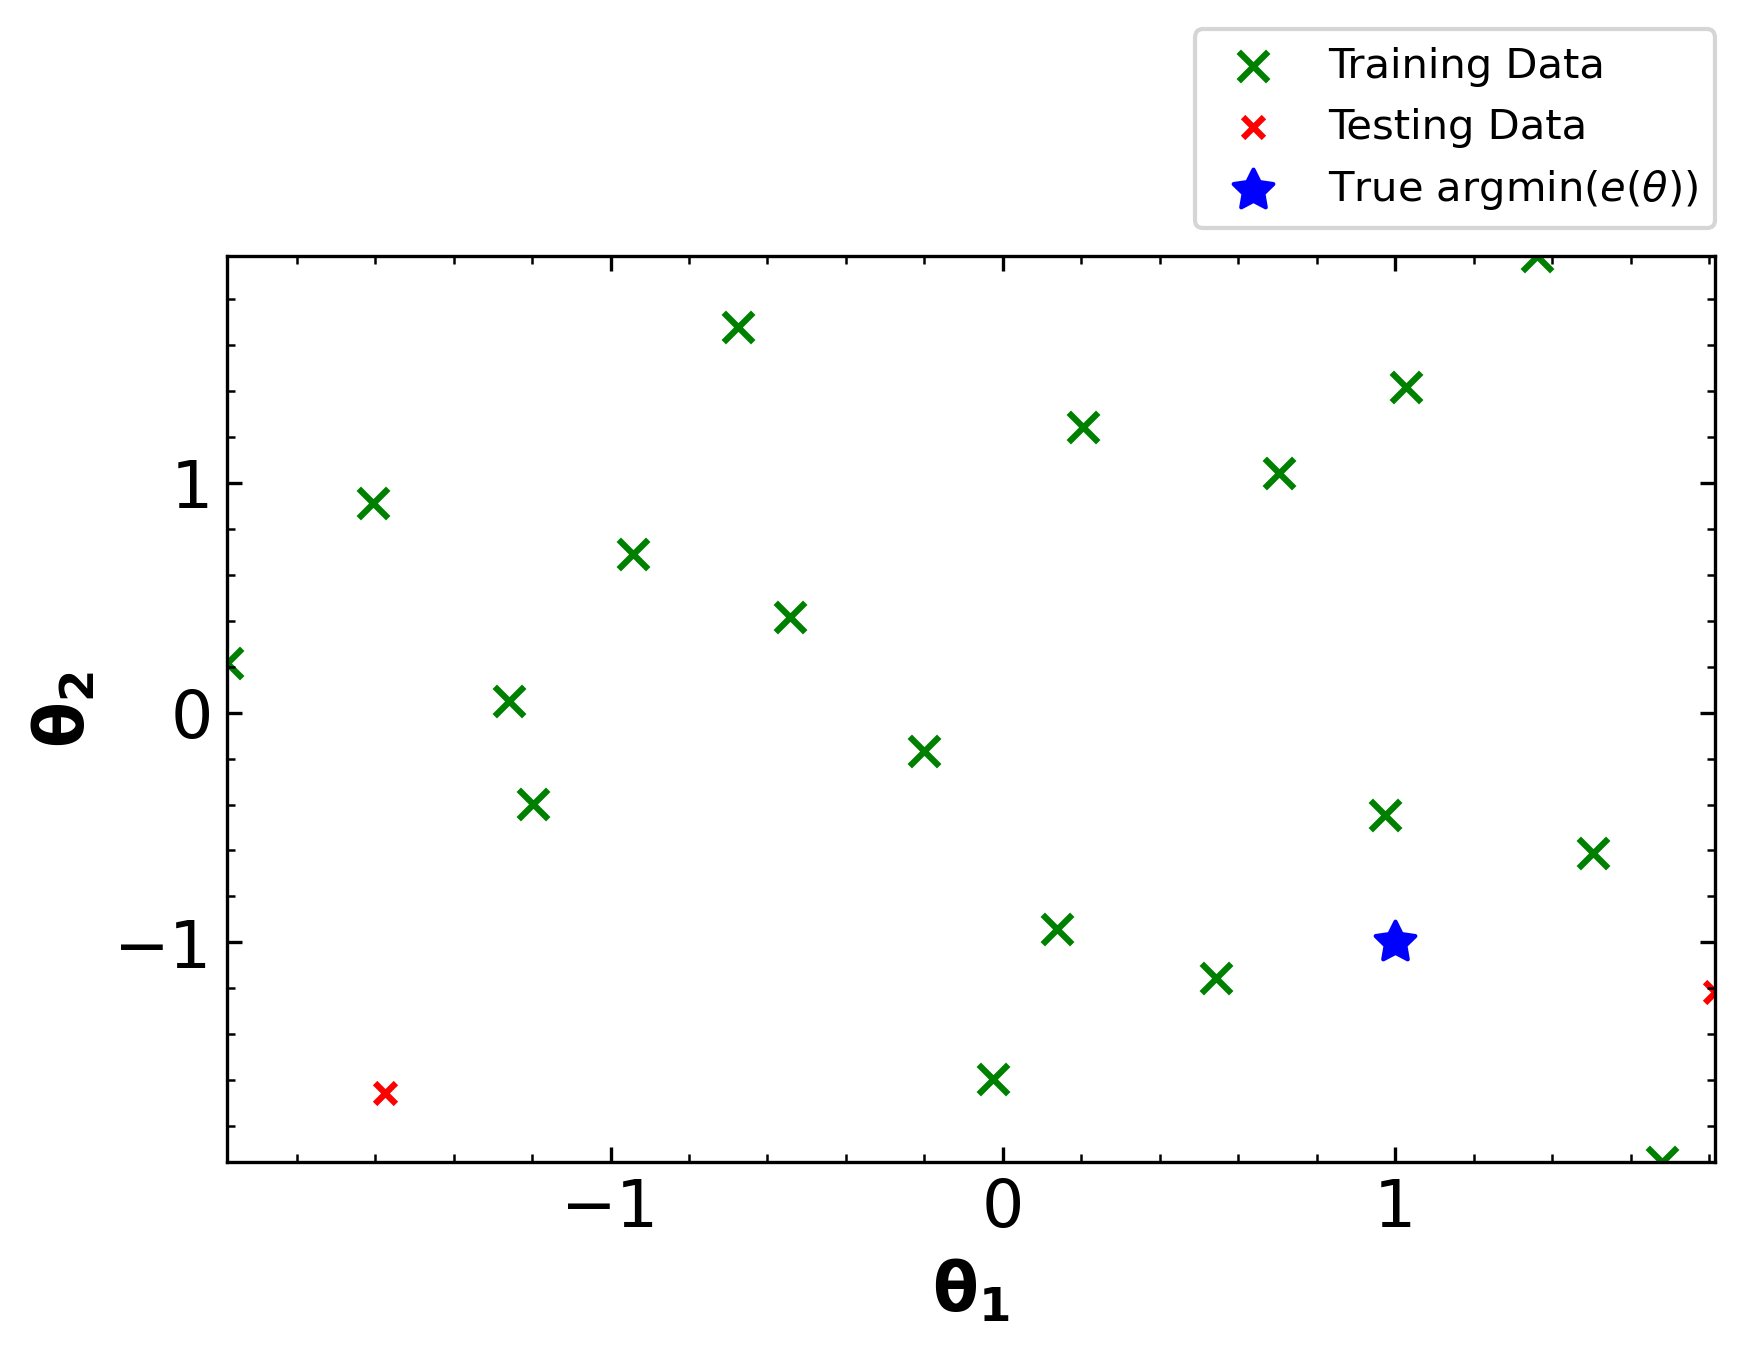

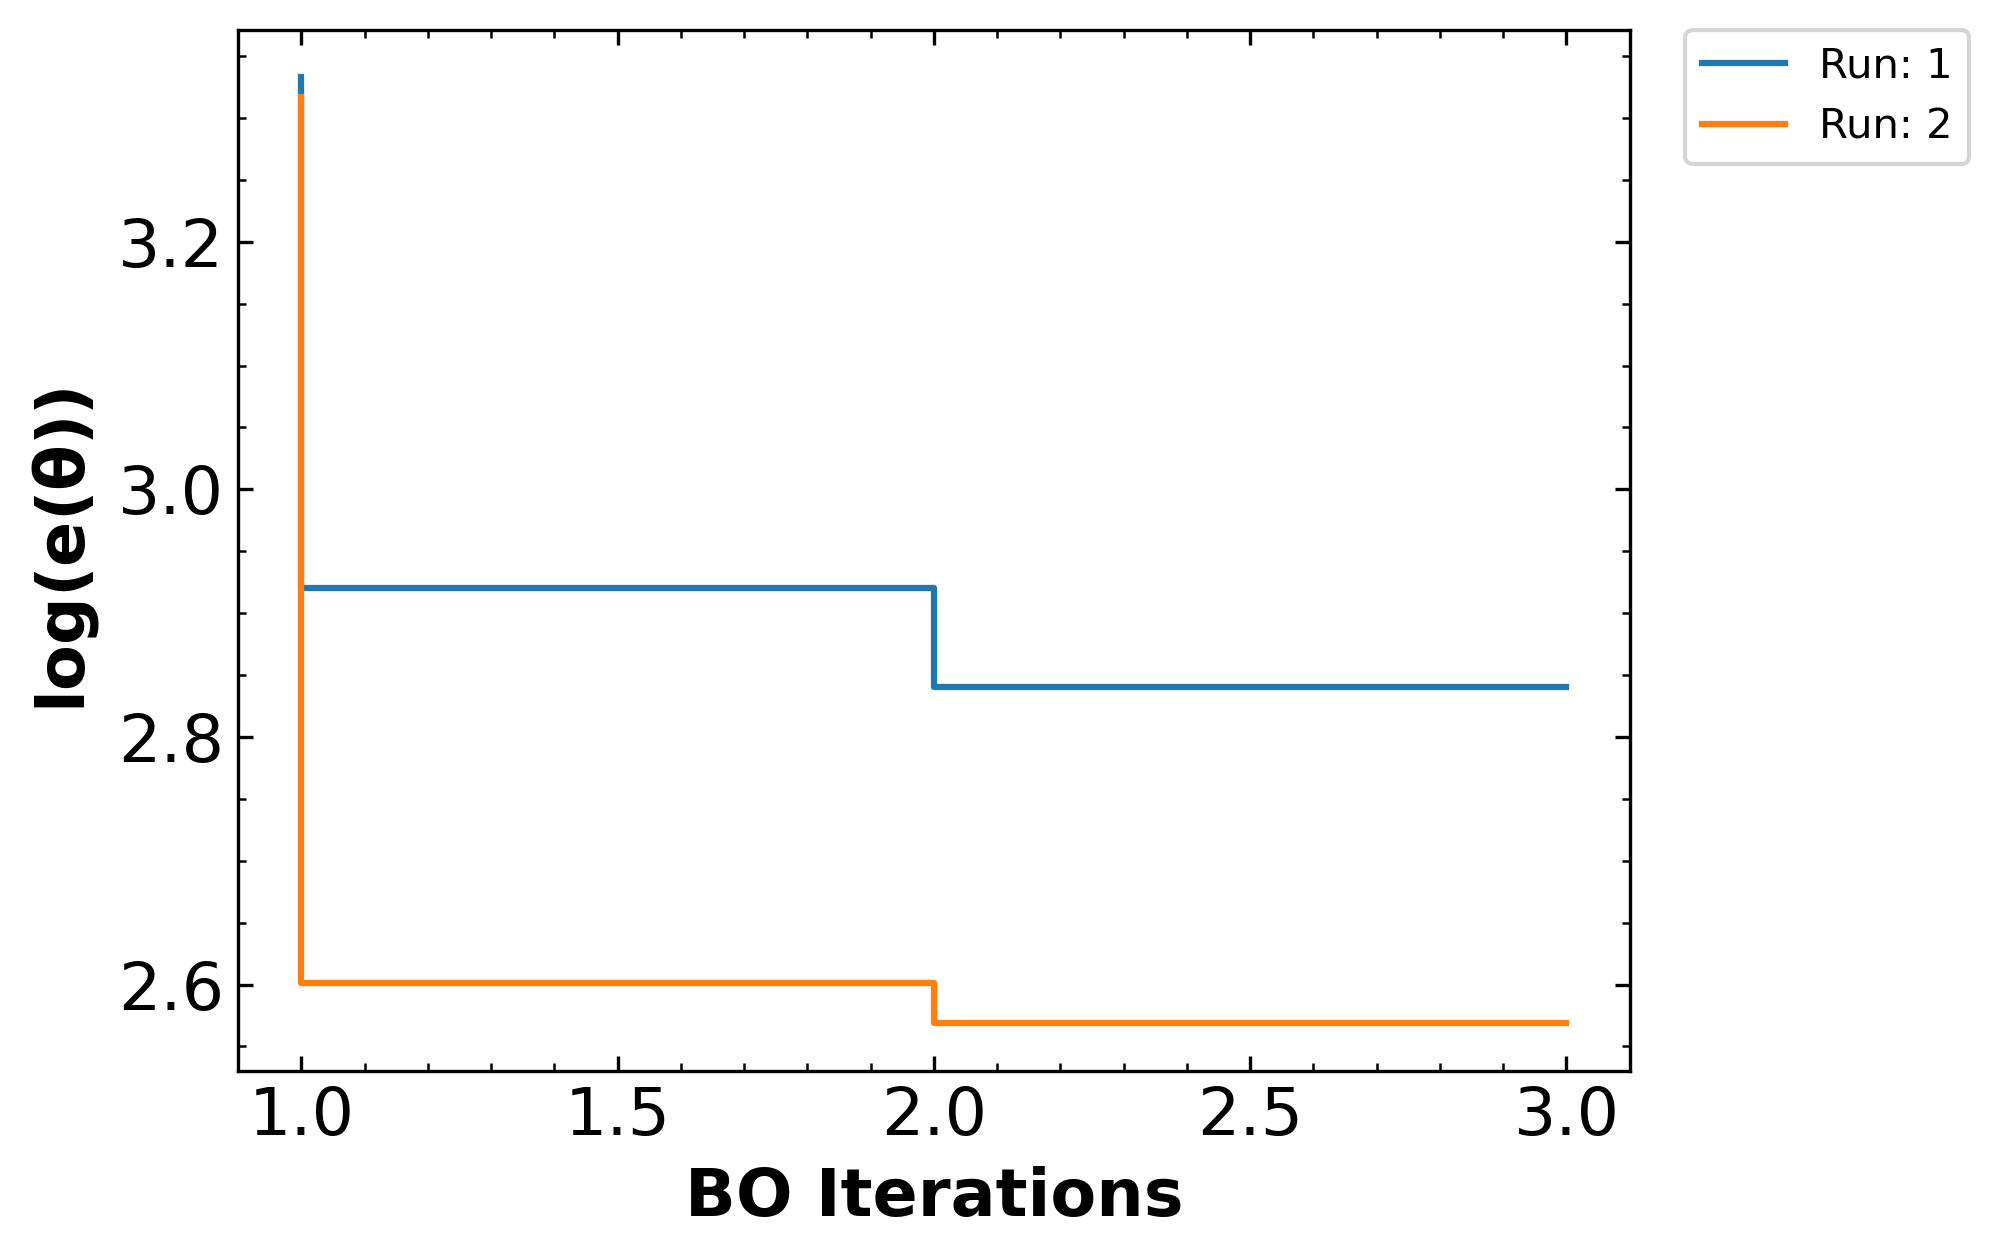

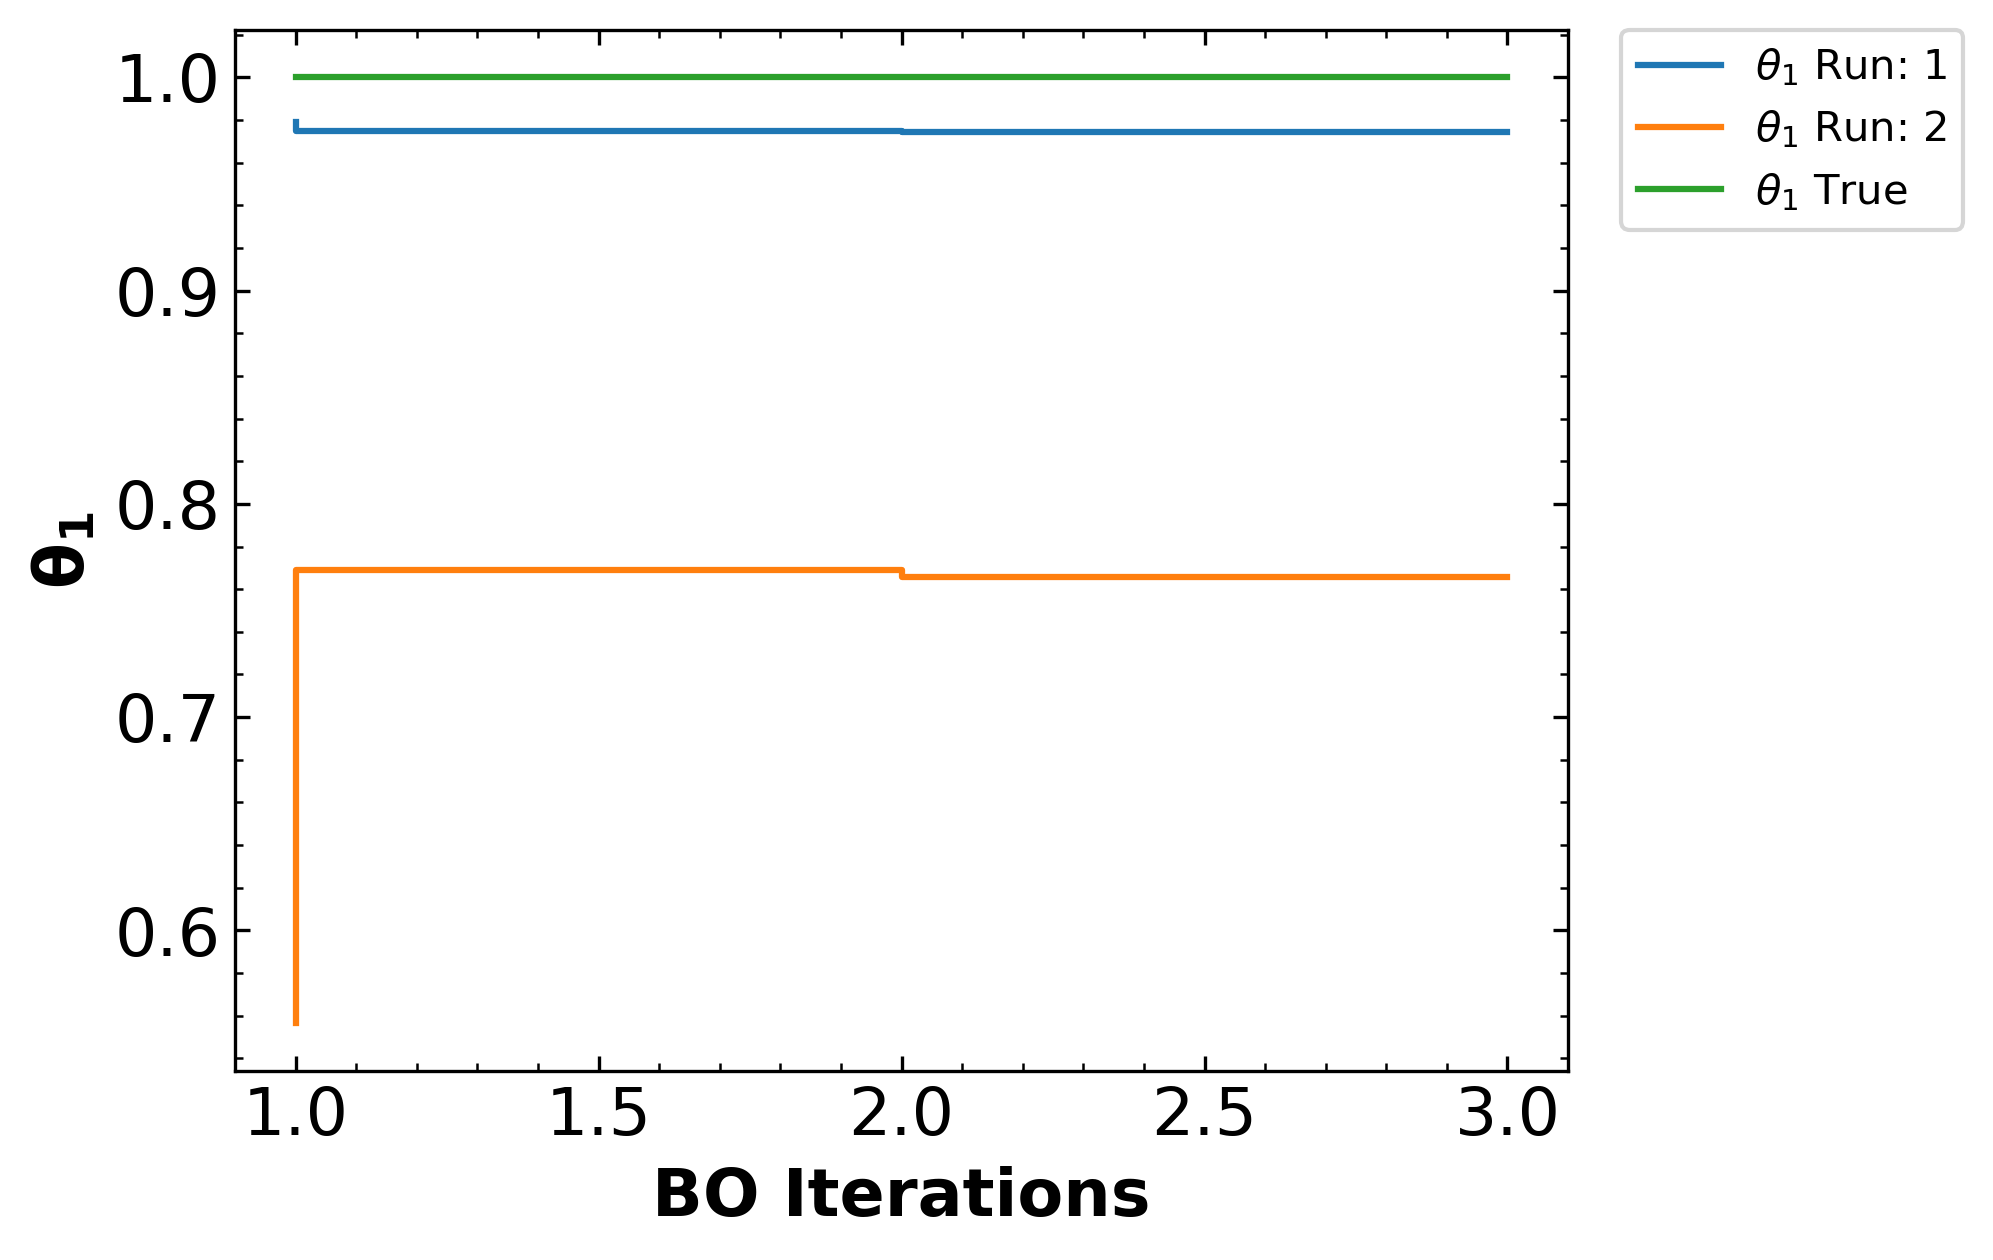

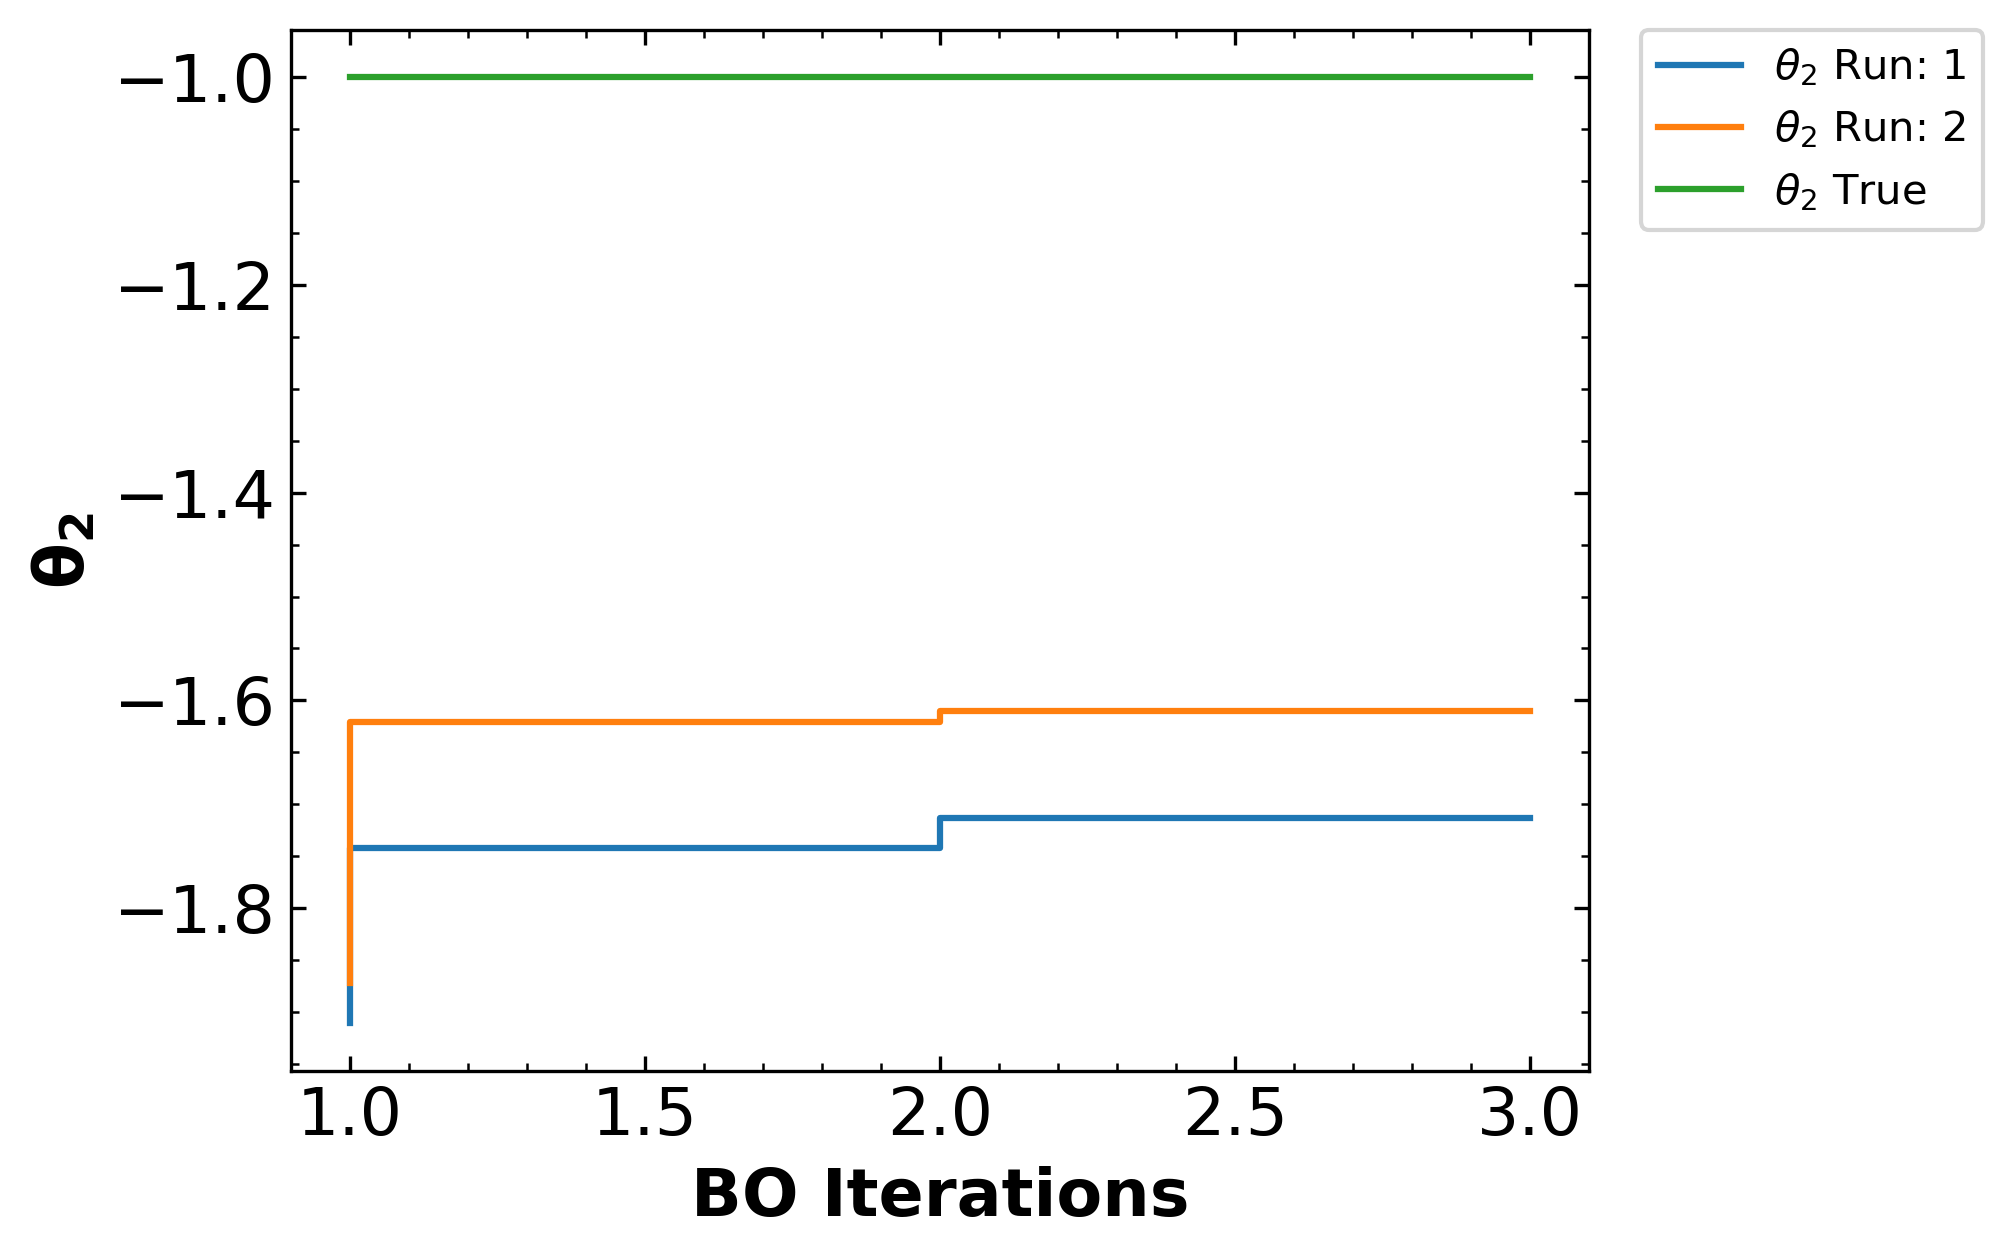

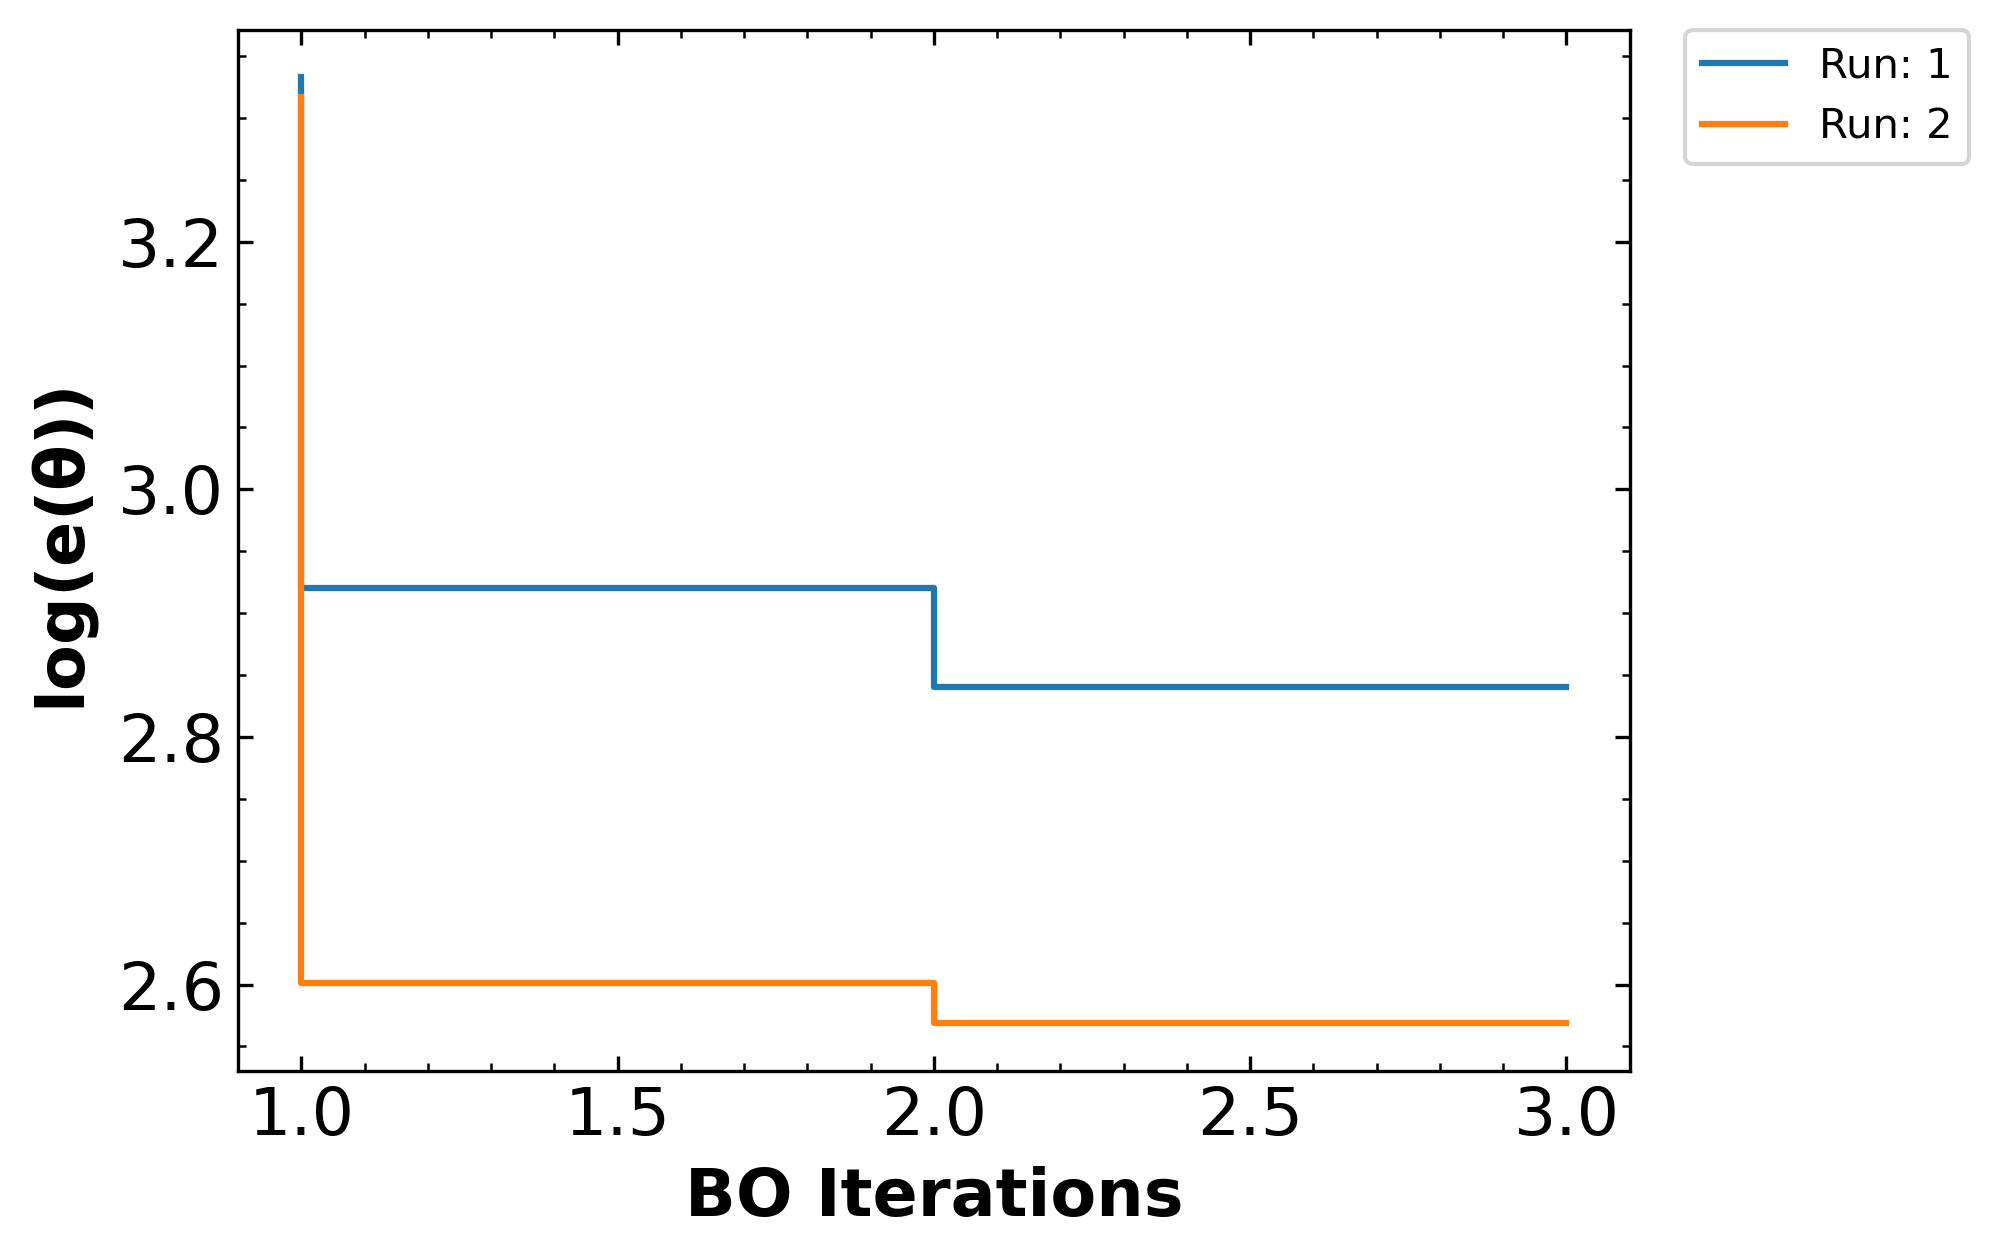

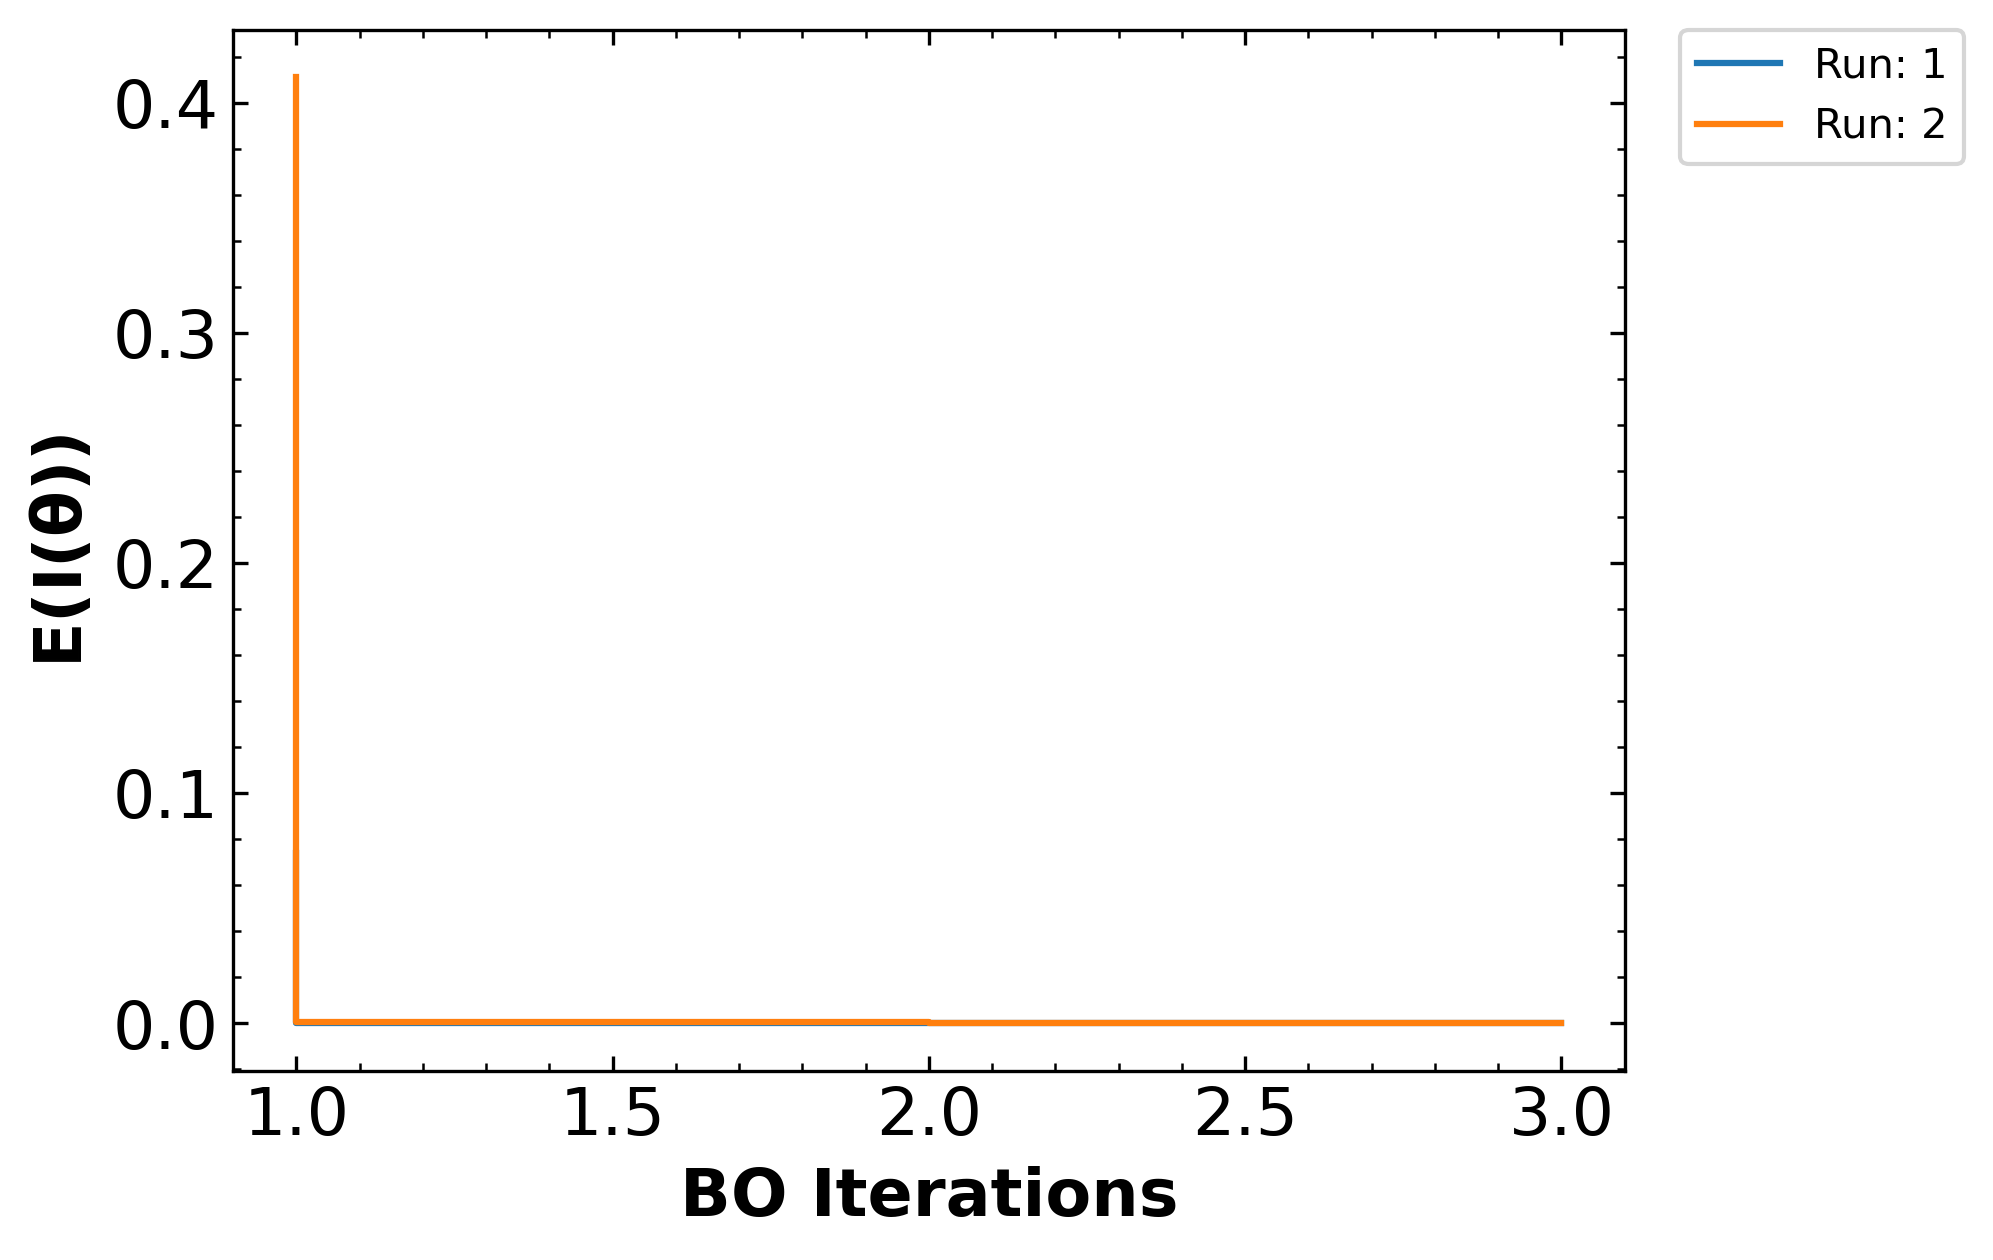

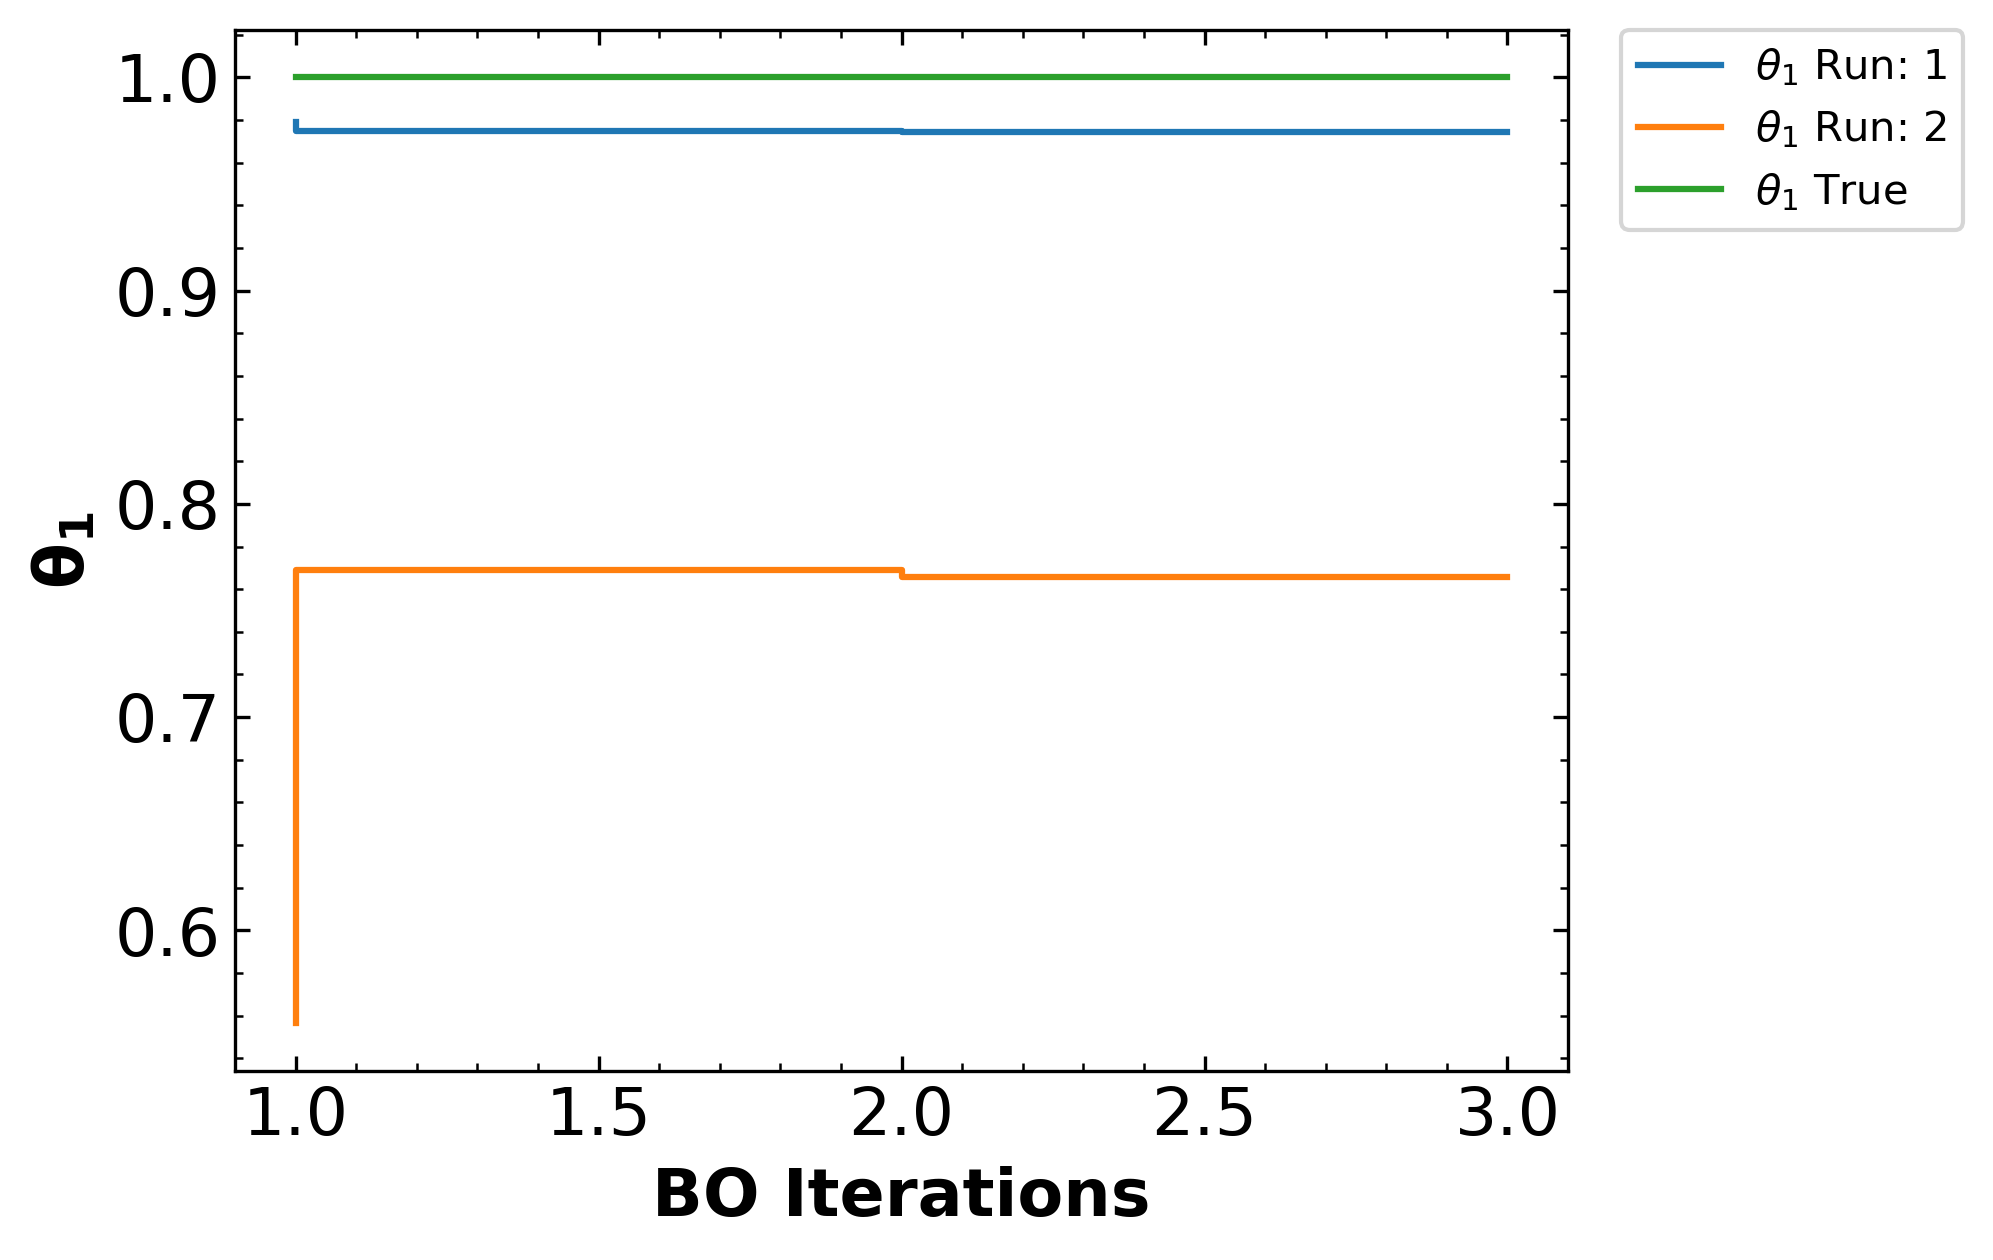

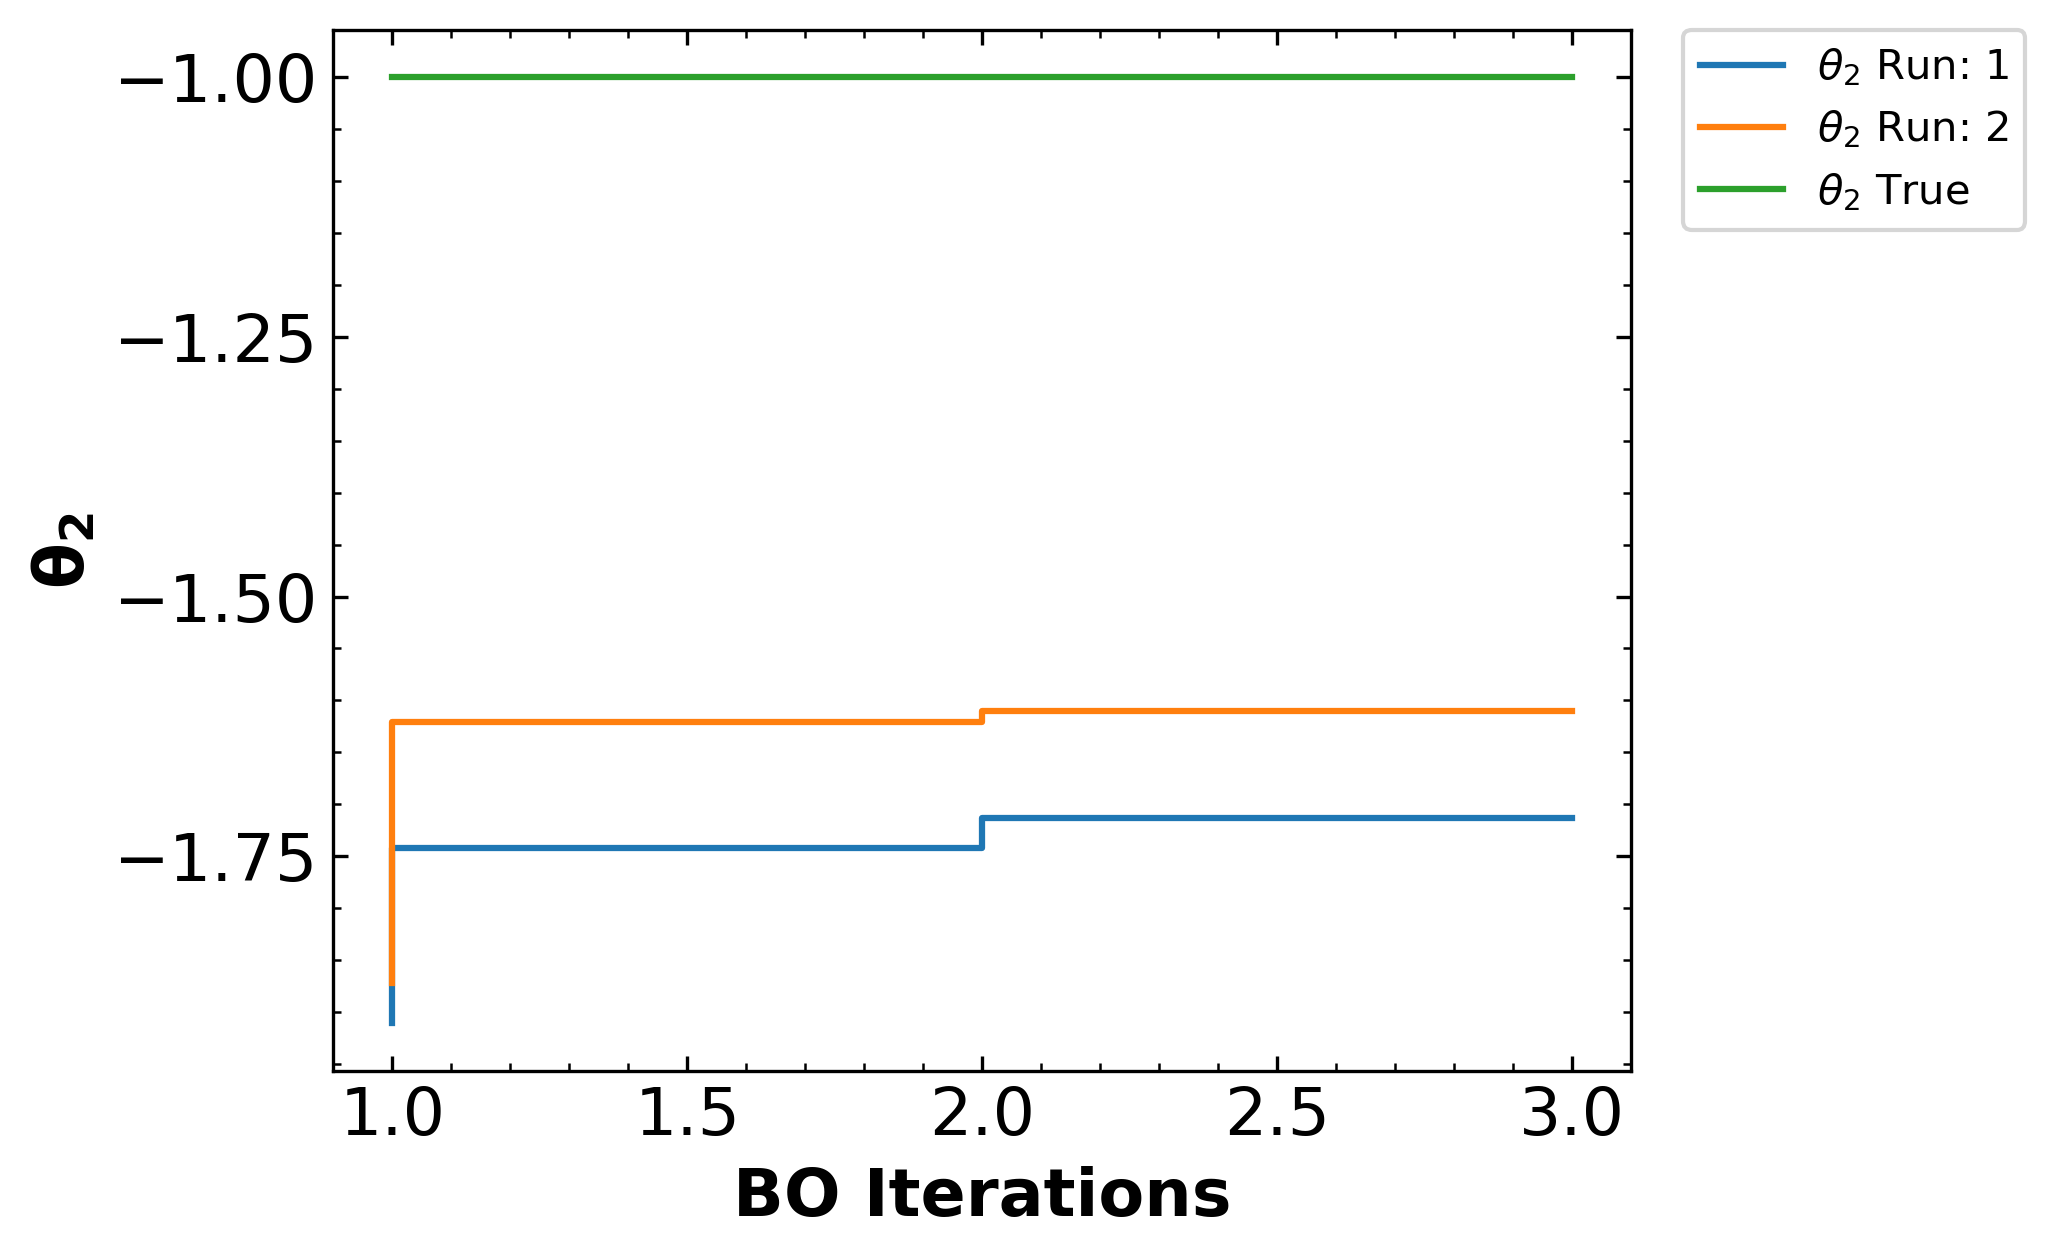

The GP predicts the lowest SSE of 1.305e+01 occurs at θ = [ 0.76582322 -1.61032014] during run 2 at BO iteration 3
At this point, the highest EI occurs at θ = [ 0.75285586 -1.62935431]


CPU times: user 18.9 s, sys: 673 ms, total: 19.5 s
Wall time: 20.3 s


In [1]:
%%time

import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime

from bo_functions_generic import gen_theta_set
from bo_functions_generic import clean_1D_arrays
from CS2_bo_functions_multi_dim import bo_iter_w_runs
from CS2_bo_functions_multi_dim import find_train_doc_path
from CS2_bo_functions_multi_dim import set_ep

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
#----------------------------------------------

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
d = len(Theta_True)
BO_iters = 3
runs = 2
train_iter = 300
noise_std = 0.1
shuffle_seed = 9
sep_fact = np.linspace(0.9,1,1)
set_lengthscale = None
skip_param_types = 0

obj = np.array(["obj"])
# obj = np.array(["obj","LN_obj"])
# emulator = False
emulator = np.array([False])
sparse_grid = np.array([False])
eval_all_pairs = False
# sparse_grid = np.array([False,True])
verbose = False
save_fig = True
save_fig = False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d=2/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))

Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(len(Xexp) == len(Yexp))

Xexp = clean_1D_arrays(Xexp)

#Define GP Testing space
LHS = False
p=20
bounds = np.array([[-2,-2],[2,2]])
# Theta1 =  np.linspace(-2,2,p) #1x10
# Theta2 =  np.linspace(-2,2,p) #1x10
# theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays 
theta_mesh = gen_theta_set(LHS = LHS, n_points = p, dimensions = d, bounds = bounds)


print("Runs:", runs)
print("BO Iterations:",BO_iters)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%")
for emul in emulator: 
    sys.stdout.flush()
    obj_use = obj
    print("-------------------")
    print("Emulator?:", emul)
    if emul == True:
        t = 100
        sparse_grid_use = sparse_grid
    else:
        t = 20
        sparse_grid_use = np.array([sparse_grid[0]]) #Sparse Grid will always be False for 2-Input
        
    for sparse in sparse_grid_use:
#         #Can set ep to 1 for sparse grid if wanted
        if sparse == True:
            obj_use =  np.array(["obj"])
        else:
            obj_use =  obj
#             ep_use = torch.tensor([1]) 
#         else:
#             ep_use = explore_bias
        print("______________________________")
        print("Sparse Grid?:", sparse)  

        for obj_func in obj_use:
            all_data_doc = find_train_doc_path(emul, obj_func, d, t)
            all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 
            print("Objective Function:", obj_func)
            print("-  -  -  -  -  -  -  -  -  -  -")
            for i in range(len(sep_fact)):
                explore_bias = set_ep(emul, obj_func, sparse)
                ep = torch.tensor([float(explore_bias)])
                print("Separation Factor Train/Test:", str(np.round(sep_fact[i],3)))
                print("Lengthscale Set To:", set_lengthscale)
                print("Explore Bias Multiplier:", str(np.round(float(ep),3)))
                results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,ep, Xexp, Yexp,
                                             noise_std, obj_func, runs, sparse, emul, set_lengthscale, Theta_True, 
                                             param_dict, verbose, save_fig, shuffle_seed, DateTime, sep_fact = sep_fact[i], 
                                             LHS = LHS, skip_param_types = skip_param_types, eval_all_pairs = eval_all_pairs)
                print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2], 
                          "during run", results[1], "at BO iteration", results[0])
                print("At this point, the highest EI occurs at \u03B8 =", results[4])
                print("\n")

In [2]:
SSE_matrix = np.array([[0.04776216, 0.31411546, 0.13075961],
 [0.04776171, 0.31287431, 0.100031  ]])
SSE_matrix = np.array([[-0.70103865, -1.56881421, -4.5355792 ],
 [-0.70103866, -1.56881405, -4.27605561]])
print(SSE_matrix[[0,1]])
print(SSE_matrix.shape)
argmin = np.array(np.where(np.isclose(SSE_matrix, np.amin(SSE_matrix),rtol=abs(np.amin(SSE_matrix)*1e-6))==True))
print(argmin)

[[-0.70103865 -1.56881421 -4.5355792 ]
 [-0.70103866 -1.56881405 -4.27605561]]
(2, 3)
[[0]
 [2]]


In [3]:
print(argmin)
# print(SSE_matrix[1,0])
argmin[0]

[[0]
 [2]]


array([0])

In [4]:
# print(argmin[:,1])

In [5]:
if len(argmin) > 1:
    rand_ind = np.random.randint(argmin.shape[1]) #Chooses a random point with the minimum value
    argmin = argmin[:,rand_ind]
    print(argmin)

[0 2]


In [6]:
Theta_Best_matrix = np.random.randint(1, size = (2,3,3))
Theta_Best_all = np.array(Theta_Best_matrix[tuple(argmin)+(Ellipsis,)])
print(Theta_Best_all)

[0 0 0]


In [7]:
w = []
print(len(w))

0
